# Data Description

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud. 
For each TransactionID in the test set, you must predict a probability for the isFraud variable.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

1. [Further Information and related discussion](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)
2. [Kaggler's insight](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#610146)
3. [Labelling logic](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#589276)

    It's a good question.

    Yes, they're all real data, no synthetic data. The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).
    However, in real world fraudulent activity might not be reported, e.g. cardholder was unaware, or forgot to report in time and beyond the claim period, etc. In such cases, supposed fraud might be labeled as legit, but we never could know of them. Thus, we think they're unusual cases and negligible portion.
4. [Main Ideas from Grandmaster's EDA](https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id/notebook)

Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

# Overall Summary

There are too much data to be fed into to later model development. Hence, feature selection is required here.

Firstly, we group the features based on whether their missing values are happening together. This results multiple pages for example v1 until v11 are related via their missing values.

Since it is computationally infeasible to compute the correlation matrix of all 300++ vesta rich features, we compute correlation matrix of smaller pages that are found earlier. From that, we futher group the features based correlation value (i.e.: see `naive_reduce` function). Counting and temporal attributes are also grouped via this correlation selection approach.

For identity dataset, we see that that identity info and fraudelent transaction are not strongly correlated (neither positve nor negative). Furthermore, not all identity info are provided, then we decide not to include them as input features for model developed.

EDA is seperated into 2 parts, first part focuses on correlation selection, while second part focuses on preprocessing.

- [x] TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- [x] TransactionAMT: transaction payment amount in USD
- [x] ProductCD: product code, the product for each transaction
- [x] card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- [x] addr: address
- [x] dist: distance
- [x] P_ and (R__) emaildomain: purchaser and recipient email domain
- [x] C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- [x] D1-D15: timedelta, such as days between previous transaction, etc.
- [x] M1-M9: match, such as names on card and address, etc.
- [x] Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import sklearn as sk

# Utility Functions

In [ ]:
def vesta_col_sel(cols, prefix):
    return [c for c in cols if c.startswith(prefix)]

def flatten_list(li):
    return reduce(lambda acm,cur: acm + cur, li)

def union_lists(lists):
    from functools import reduce
    return reduce(lambda acm, cur: acm.union(set(cur)), lists, set())

def naive_reduce(cor_mat, cor_p = 0.9):
    xs = set(cor_mat.columns)
    ys = set(cor_mat.index)
    subsets = []
    while xs != set():
        cur_col = xs.pop()
        mask = abs(cor_mat[cur_col]) > cor_p
        sel_set = list(mask[mask].index)
        if cur_col not in sel_set: 
            sel_set.append(cur_col)
        subsets.append(sel_set)
        xs = xs.difference(sel_set)
        ys = ys.difference(sel_set)
        # note that correlation matrix is symetric
        cor_mat = cor_mat.loc[ys][xs]

    return subsets

def get_suffix_digit(s):
    for i, _ in enumerate(s):
        if s[i:].isdigit():
            return i, int(s[i:]), s[:i]
        
def sort_prefix_numeric(seq):
    'same prefix'
    idx, _, prefix = get_suffix_digit(seq[0])
    mp = lambda c : int(c[idx:])
    res = [mp(s) for s in seq]
    res = sorted(res)
    return [f'{prefix}{s}' for s in res]

def nan_groups(df):
    nan_res = df.isna().sum()
    
    arg_unique = lambda seq, k: list(seq[seq == k].index)

    nan_nonzero_counts = np.delete(nan_res.unique(), 0)

    nan_grp = {c:arg_unique(nan_res, c) for c in nan_nonzero_counts}
    nan_grp = {c:grp for c,grp in nan_grp.items() if len(grp) > 1}

    for c, grp in nan_grp.items():
        blank_row_count = df[grp].isna().all(axis=1).sum()
        assert(blank_row_count==c) # ensure that nan happens together
    nan_grp = list(nan_grp.values())
    return nan_grp

In [2]:
# the file is very large, then read some of it
from zipfile import ZipFile
with ZipFile('ieee-fraud-detection.zip', 'r') as f:
    transaction_df = pd.read_csv(f.open('train_transaction.csv'))

In [164]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 395 entries, TransactionID to Offset_TransactionDT
dtypes: float64(376), int64(5), object(14)
memory usage: 1.7+ GB


In [165]:
transaction_df.shape, transaction_df['isFraud'].value_counts() / transaction_df['isFraud'].count() * 100

((590540, 395),
 0    96.500999
 1     3.499001
 Name: isFraud, dtype: float64)

"TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183."

In [166]:
transaction_df['Offset_TransactionDT'] = transaction_df['TransactionDT'] - 86400
last_dt = max(transaction_df['Offset_TransactionDT'].describe()) / 86400
{
    last_dt // 30: 'months' , 
    last_dt % 30: 'days'
}

{6.0: 'months', 1.9992013888888778: 'days'}

### Transaction

Text(0.5, 1.0, 'Fraud Transaction vs Time')

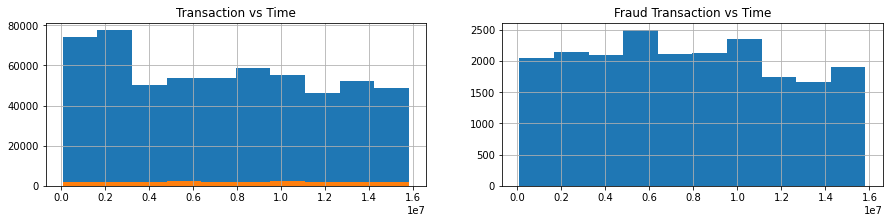

In [167]:
fig, axs = plt.subplots(ncols=2,figsize=(15,3))
transaction_df.groupby(by='isFraud')['TransactionDT'].hist(ax=axs[0]); axs[0].set_title('Transaction vs Time')
transaction_df['TransactionDT'][transaction_df['isFraud'].astype('bool')].hist(ax=axs[1]); axs[1].set_title('Fraud Transaction vs Time')

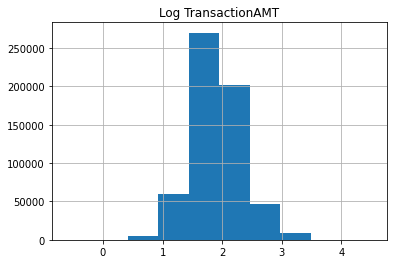

In [168]:
np.log10(transaction_df[['TransactionAmt']]).hist();plt.title('Log TransactionAMT');

### ProductCD

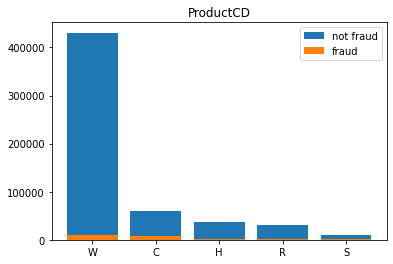

In [169]:
res = transaction_df.groupby(by='isFraud')['ProductCD'].value_counts()
plt.title('ProductCD')
plt.bar(res[1].index, res[0], label='not fraud')
plt.bar(res[1].index, res[1], label='fraud')
plt.legend();

### Email domain

In [170]:
transaction_df['R_emaildomain'].isna().sum(), transaction_df['P_emaildomain'].isna().sum(), len(transaction_df)

(453249, 94456, 590540)

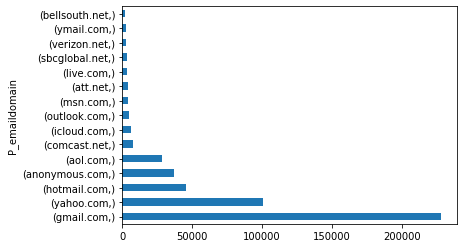

In [171]:
transaction_df[['P_emaildomain']].value_counts().head(15).plot.barh();

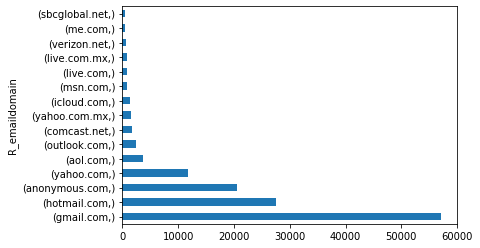

In [172]:
transaction_df[['R_emaildomain']].value_counts().head(15).plot.barh();

### distance, addr

Note that addr1, addr2 are categorical, but addr2 is pretty much the same across the column (i.e.: no information), hence it is discarded.

<AxesSubplot:>

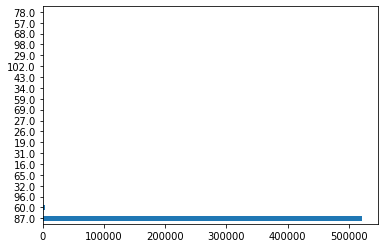

In [263]:
transaction_df['addr2'].value_counts().head(20).plot.barh() 

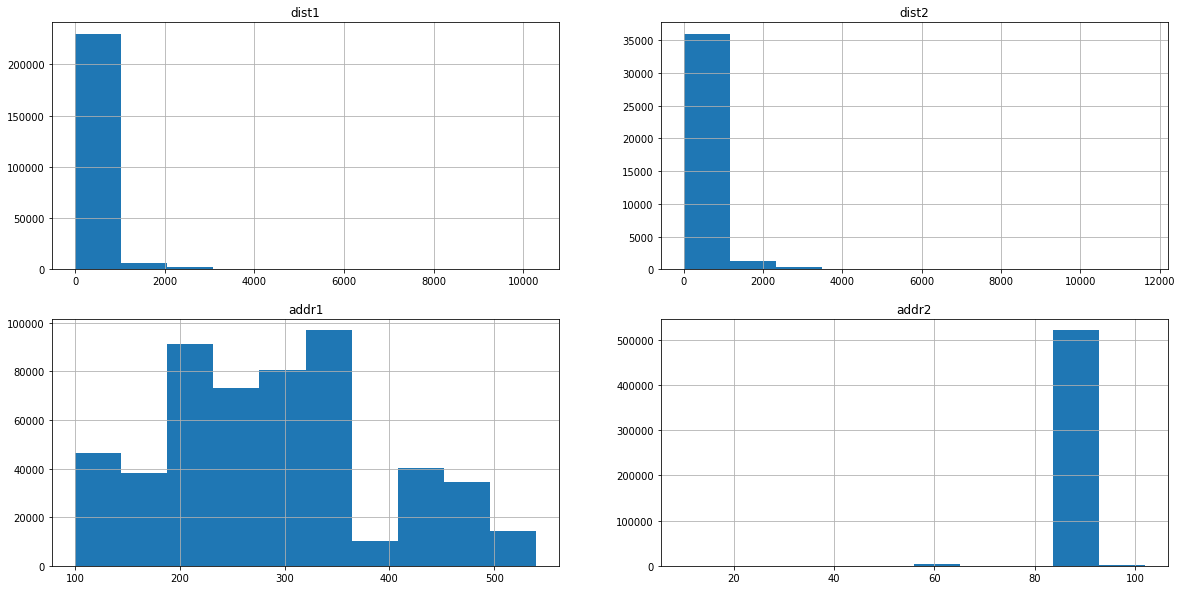

In [264]:
_, axs = plt.subplots(nrows = 2, ncols=2, figsize=(20,10))
cols = ['dist1', 'dist2', 'addr1', 'addr2']
for col, ax in zip(cols, axs.flatten()):
    transaction_df[col].hist(ax = ax)
    ax.set_title(col)

In [174]:
f = lambda pre : vesta_col_sel(transaction_df.columns, pre)

vesta_col_grp = {
    'counting' : f('C'),
    'timedelta' : f('D'),
    'match' : f('M'),
    'features': f('V'),
    'card' : f('card'),
    'transaction':f('Transaction'),
    'addr' : f('addr')
}

remaining_col = set(transaction_df.columns) - union_lists(vesta_col_grp.values())
vesta_col_grp['remaining'] = list(remaining_col)
assert(set(transaction_df.columns) == union_lists(vesta_col_grp.values()))
vesta_col_grp['remaining'], vesta_col_grp['card']

(['ProductCD',
  'R_emaildomain',
  'Offset_TransactionDT',
  'isFraud',
  'P_emaildomain',
  'dist2',
  'dist1'],
 ['card1', 'card2', 'card3', 'card4', 'card5', 'card6'])

# Structally Same via NAN

In [372]:
transaction_nan_grps = nan_groups(transaction_df)
len(transaction_nan_grps)

19

In [373]:
nan_other_grp = [['addr1', 'addr2'], ['D8', 'D9'], ['M1', 'M2', 'M3'], ['M8', 'M9']]
nan_other_grp, len(nan_other_grp)

([['addr1', 'addr2'], ['D8', 'D9'], ['M1', 'M2', 'M3'], ['M8', 'M9']], 4)

In [374]:
def extract_prefixes(seq):
    return set([s[0] for s in seq])
def arg_pred(seq, pred):
    return [c for c,s in enumerate(seq) if pred(s)]
def argcol_mix(seqs):
    major = [extract_prefixes(s) for s in seqs]
    return [seq for seq, mjr in zip(seqs, major) if len(mjr) > 1]
def is_consec(ns):
    res = np.diff(sorted(ns))
    return res[res==1].all()

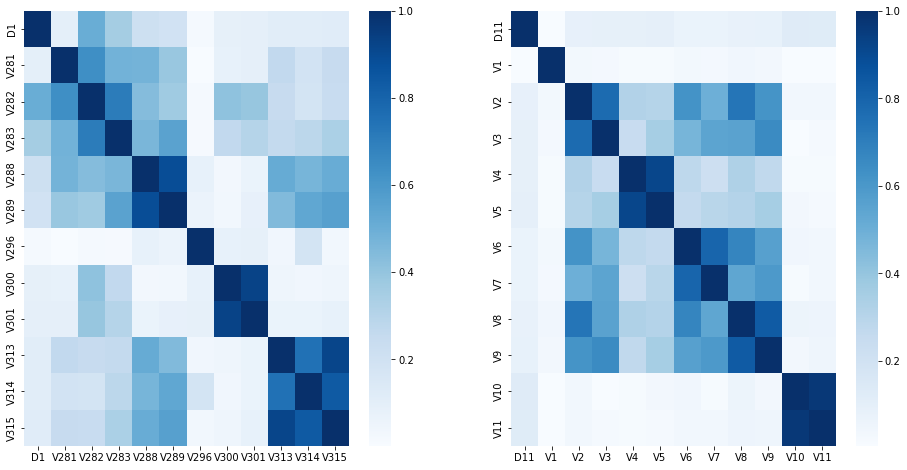

In [384]:
prefixes = [extract_prefixes(seq) for seq in transaction_nan_grps]
idxs = arg_pred(prefixes, lambda s: 'V' in s and len(s) > 1)

_, axs = plt.subplots(ncols=2,figsize=(16, 8))

for i, ax in zip(idxs, axs):
    cols = transaction_nan_grps[i]
    cor = transaction_df[cols].corr()
    sns.heatmap(abs(cor), ax=ax, cmap='Blues')

D1 is related to V281 ~ V315 groups

D11 is related to V1 ~ V11

However, they are not really correlated with the V's groups. Hence, D1, D11 are discarded from V's groups

In [390]:
prefixes = [extract_prefixes(seq) for seq in transaction_nan_grps]
idxs = arg_pred(prefixes, lambda s: 'V' in s and len(s) > 1)
for i in idxs:
    seq = transaction_nan_grps[i]
    remains = [s for s in seq if s.startswith('D')]
    transaction_nan_grps[i] = [s for s in seq if not s.startswith('D')]
    if remains not in nan_other_grp:
        nan_other_grp.append(remains) # avoid repeatly adding

6

In [392]:
prefixes = [extract_prefixes(seq) for seq in transaction_nan_grps]
idxs = arg_pred(prefixes, lambda s: 'V' in s)
vesta_rich_grp = [transaction_nan_grps[i] for i in idxs]

for grp in vesta_rich_grp:
    ns = [int(v[1:]) for v in grp]
    # assert that all V's groups are consecutive
    assert(is_consec(ns))

f'{len(vesta_rich_grp)}, groups'

'15, groups'

In [393]:
{
    'flatten group count': len(flatten_list(vesta_rich_grp)),
    'original count': len(vesta_col_grp['features'])
}

{'flatten group count': 339, 'original count': 339}

In [444]:
print(nan_other_grp)

[['addr1', 'addr2'], ['D8', 'D9'], ['M1', 'M2', 'M3'], ['M8', 'M9'], ['D1'], ['D11']]


# Feature Selection Based on Correlation

In [396]:
len(vesta_rich_grp), len(flatten_list(vesta_rich_grp))

(15, 339)

In [397]:
vesta_subset_grp  = []
vesta_subset_pages = []
vesta_cor_mats = []

for grp in vesta_rich_grp:
    cor = transaction_df[grp].corr()
    vesta_cor_mats.append(cor)
    
    reduced_grp = naive_reduce(cor, 0.8)
    reduced_grp = sorted(reduced_grp)
    
    vesta_subset_grp += reduced_grp
    vesta_subset_pages.append(reduced_grp)

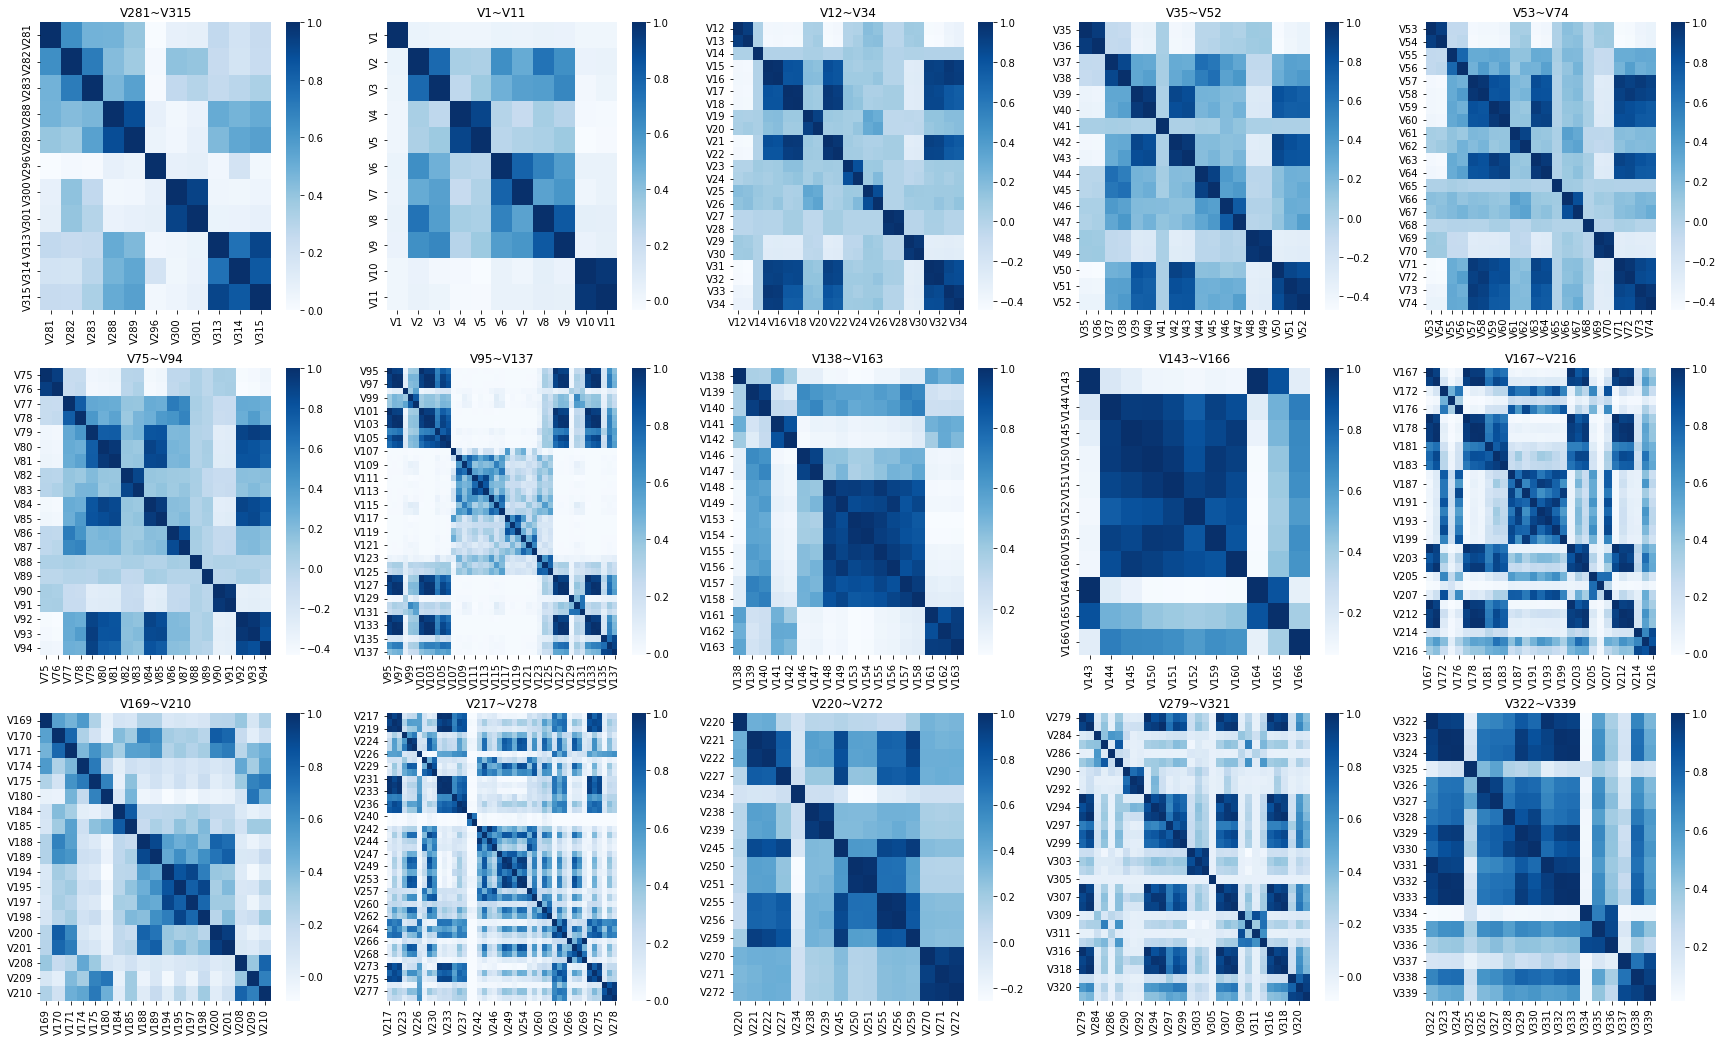

In [398]:
def plot_cor_mat_seq(mats):
    # subplots(nrows,ncols, figsize = (x,y))
    k = 6
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(5*k, 3*k))
    for cor, ax in zip(mats, axs.flatten()):
        ax.set_title(f'{cor.index[0]}~{cor.index[-1]}')
        sns.heatmap(cor,ax=ax, cmap='Blues')
        
plot_cor_mat_seq(vesta_cor_mats)

In [399]:
sel_first = lambda xss: [xs[0] for xs in xss]
reduced_vesta_features = [sel_first(page) for page in vesta_subset_pages]
reduced_cor_mats = [transaction_df[page].corr() for page in reduced_vesta_features]

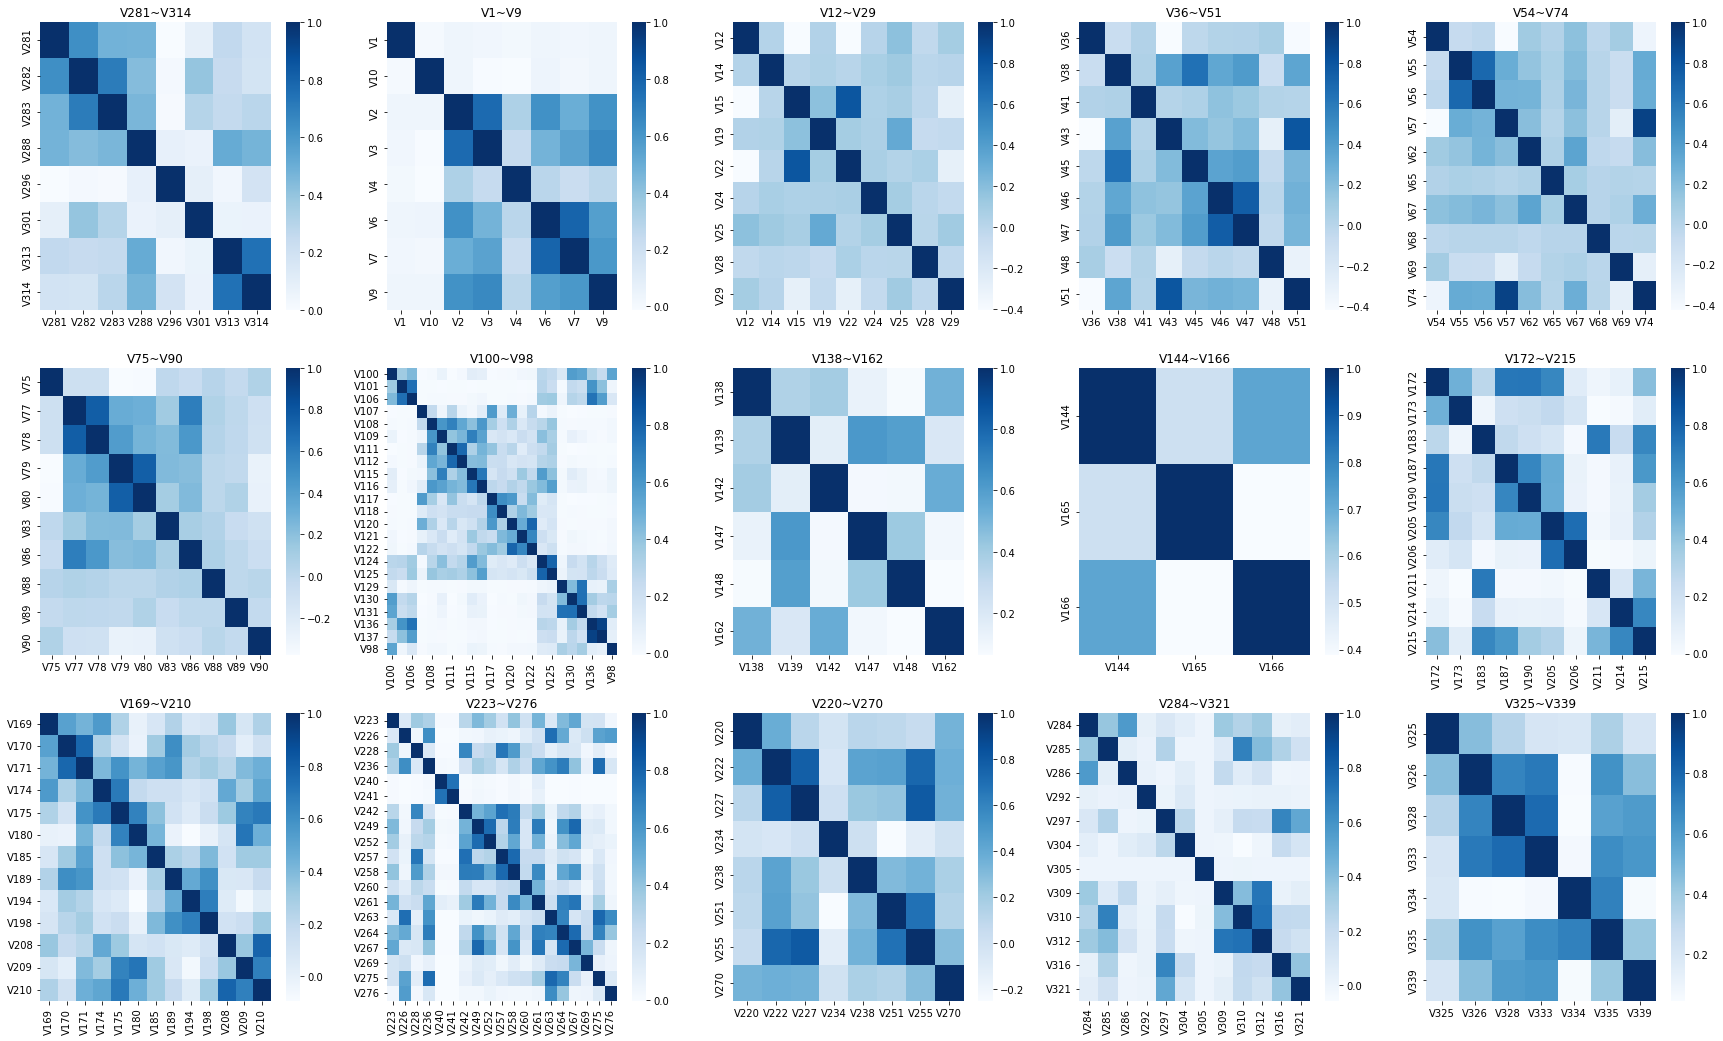

In [400]:
plot_cor_mat_seq(reduced_cor_mats) # reduced

In [401]:
vesta_subset_grp = [sorted(grp) for grp in vesta_subset_grp]
prv_sz = len(union_lists(vesta_rich_grp))
cur_sz= len(flatten_list(vesta_subset_grp))
assert(prv_sz == cur_sz)
{
    'reduced features number': len(vesta_subset_grp),
    'full' :len(flatten_list(vesta_rich_grp))
}

{'reduced features number': 155, 'full': 339}

## Counting Features

<AxesSubplot:>

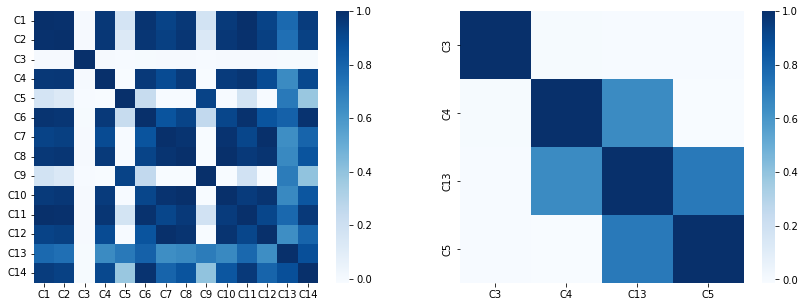

In [402]:
c_cor =  transaction_df[vesta_col_grp['counting']].corr()
count_feature_subset = naive_reduce(c_cor, 0.8)

prv_sz = len(vesta_col_grp['counting'])
cur_sz = len(flatten_list(count_feature_subset))
assert(prv_sz == cur_sz)
_, axs = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(c_cor, ax = axs[0], cmap='Blues')
reduced_cor = transaction_df[sel_first(count_feature_subset)].corr()
sns.heatmap(reduced_cor, ax=axs[1], cmap='Blues')

## Time Features

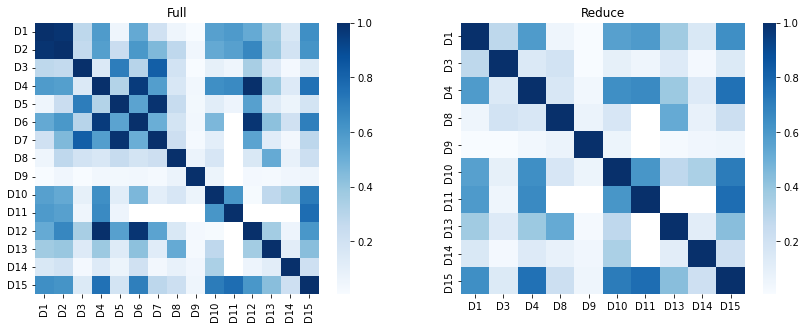

In [403]:
c_cor =  transaction_df[vesta_col_grp['timedelta']].corr()
time_subsets = naive_reduce(c_cor, 0.8)

prv_sz = len(vesta_col_grp['timedelta'])
cur_sz = len(flatten_list(time_subsets))
assert(prv_sz == cur_sz)

time_subsets = [[int(t[1:]) for t in subset] for subset in time_subsets]
time_subsets = sorted(sorted(ts) for ts in time_subsets)
time_subsets = [[f'D{d}' for d in ts] for ts in time_subsets]

_, axs = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(c_cor, ax = axs[0], cmap='Blues'); axs[0].set_title('Full')
reduced_cor = transaction_df[sel_first(time_subsets)].corr()
sns.heatmap(reduced_cor, ax=axs[1], cmap='Blues'); axs[1].set_title('Reduce');

## Matching Attributes

In [404]:
{
    m:transaction_df[m].unique() for m in vesta_col_grp['match']
}

{'M1': array([True, nan, False], dtype=object),
 'M2': array([True, nan, False], dtype=object),
 'M3': array([True, nan, False], dtype=object),
 'M4': array(['M2', 'M0', nan, 'M1'], dtype=object),
 'M5': array([False, True, nan], dtype=object),
 'M6': array([True, False, nan], dtype=object),
 'M7': array([nan, False, True], dtype=object),
 'M8': array([nan, False, True], dtype=object),
 'M9': array([nan, False, True], dtype=object)}

In [405]:
cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
transaction_df[cols] = transaction_df[cols].replace({'T':True, 'F':False})
transaction_df[cols]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,True,True,True,M2,False,True,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,True,True,NaN,NaN,NaN
2,True,True,True,M0,False,False,False,False,False
3,NaN,NaN,NaN,M0,True,False,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,True,True,True,M0,True,False,False,False,True
590536,True,False,False,M0,False,True,False,False,False
590537,True,False,False,NaN,NaN,True,NaN,NaN,NaN
590538,True,True,True,M0,False,True,NaN,NaN,NaN


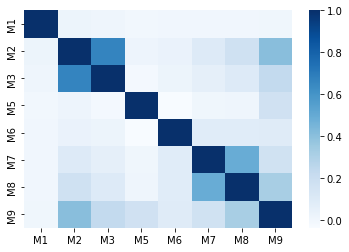

In [406]:
mask = transaction_df[vesta_col_grp['match']].drop('M4', axis=1)
cor = mask.astype('float').corr()
sns.heatmap(cor, cmap='Blues');

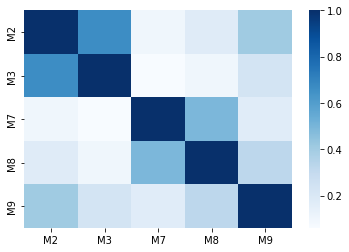

In [407]:
tmp = 'M2 M3 M7 M8 M9'.split()
sns.heatmap(cor.loc[tmp,tmp], cmap='Blues');

## Card Attribute

In [408]:
transaction_df[vesta_col_grp['card']].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


<AxesSubplot:>

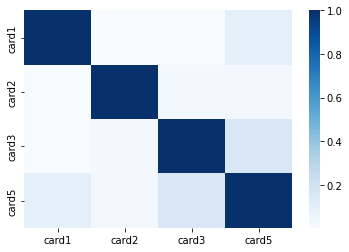

In [409]:
cor = transaction_df[vesta_col_grp['card']].corr()
sns.heatmap(abs(cor), cmap='Blues')

In [410]:
transaction_df[['card4']].value_counts(dropna=False)

card4           
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
dtype: int64

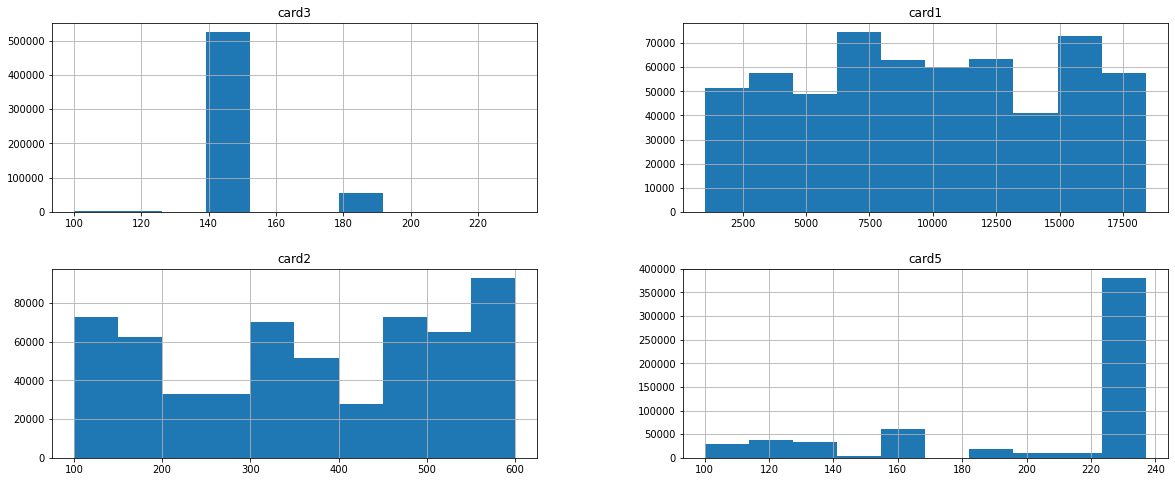

In [411]:
cards = vesta_col_grp['card']
cards = set(cards).difference(['card4'])
transaction_df[cards].hist(figsize=(20,8));

In [412]:
vesta_col_grp.keys()

dict_keys(['counting', 'timedelta', 'match', 'features', 'card', 'transaction', 'addr', 'remaining'])

# Used Feature Groups

In [443]:
# quick check
cur_sz = len(flatten_list(vesta_subset_grp))
assert(cur_sz == 339)
# report
features_num = sum([len(s) for s in [count_feature_subset, time_subsets, vesta_subset_grp]])
features_num += len(['ProductCD', 'TransactionAmt', 'dist1', 'dist2', 'addr1'])
percent = features_num/ (len(transaction_df.columns) - 2)
print(features_num, len(transaction_df.columns) - 2, percent)


# output
print('target', ['isFraud'])
input_features = [['ProductCD', 'TransactionAmt', 'dist1', 'dist2', 'addr1']]
input_features.append(vesta_col_grp['card'])
input_features.append(vesta_col_grp['match'])
input_features.append(count_feature_subset)
input_features.append(time_subsets)
input_features.append(vesta_subset_grp)
for li in input_features:
    print(li, end='\n\n')

174 394 0.4416243654822335
target ['isFraud']
['ProductCD', 'TransactionAmt', 'dist1', 'dist2', 'addr1']

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

[['C3'], ['C4', 'C7', 'C2', 'C12', 'C14', 'C10', 'C11', 'C8', 'C6', 'C1'], ['C13'], ['C5', 'C9']]

[['D1', 'D2'], ['D3', 'D5', 'D7'], ['D4', 'D6', 'D12'], ['D8'], ['D9'], ['D10'], ['D11'], ['D13'], ['D14'], ['D15']]

[['V281'], ['V282'], ['V283'], ['V288', 'V289'], ['V296'], ['V300', 'V301'], ['V313', 'V315'], ['V314'], ['V1'], ['V10', 'V11'], ['V2'], ['V3'], ['V4', 'V5'], ['V6'], ['V7'], ['V8', 'V9'], ['V12', 'V13'], ['V14'], ['V15', 'V16', 'V21', 'V31', 'V32', 'V33', 'V34'], ['V19', 'V20'], ['V17', 'V18', 'V22'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30'], ['V35', 'V36'], ['V37', 'V38'], ['V41'], ['V39', 'V40', 'V42', 'V43', 'V50'], ['V44', 'V45'], ['V46'], ['V47'], ['V48', 'V49'], ['V51', 'V52'], ['V53', 'V54'], ['V55'], ['V56'], ['V57', 'V59', 'V60

# Dimension Reduction of correlated features group via PCA

In [445]:
from sklearn.decomposition import PCA
# def pca_reduce_fit_transform(df, cols, nm):
#     non_na_mask = df[cols].isna().all(axis=1)
#     non_na_idx = non_na_mask[~non_na_mask].index

#     pca = PCA(1).fit(df[cols].dropna())
#     df.loc[non_na_idx, nm] = pca.transform(df.loc[non_na_idx, cols])
    
#     return df, pca

def pca_reduce_fit(df, cols):
    non_na_mask = df[cols].isna().all(axis=1)
    non_na_idx = non_na_mask[~non_na_mask].index

    pca = PCA(1).fit(df[cols].dropna())
    
    return pca

def pca_reduce_transform(df, pca, nm):
    cols = pca.feature_names_in_
    non_na_mask = df[cols].isna().all(axis=1)
    non_na_idx = non_na_mask[~non_na_mask].index
    
    df.loc[non_na_idx, nm] = pca.transform(df.loc[non_na_idx, cols])
    
    return df, pca

# Identity EDA

In [414]:
with ZipFile('ieee-fraud-detection.zip', 'r') as f:
    id_df_ = pd.read_csv(f.open('train_identity.csv'))
id_df_.shape

(144233, 41)

In [415]:
id_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [416]:
id_df = pd.merge(id_df_,transaction_df[['TransactionID', 'isFraud']], on=['TransactionID'])
id_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


In [417]:
id_nan_grps = nan_groups(id_df)

In [418]:
id_nan_grps

[['id_03', 'id_04'],
 ['id_05', 'id_06'],
 ['id_07', 'id_08'],
 ['id_09', 'id_10'],
 ['id_11', 'id_28', 'id_29'],
 ['id_15', 'id_35', 'id_36', 'id_37', 'id_38'],
 ['id_22', 'id_23', 'id_27']]

In [419]:
vesta_id_col_grp = {'id': vesta_col_sel(id_df.columns, 'id')}
remaining_col = set(id_df.columns) - union_lists(vesta_id_col_grp.values())
vesta_id_col_grp['remaining'] = remaining_col
assert(set(id_df.columns) == union_lists(vesta_id_col_grp.values()))
vesta_id_col_grp['remaining']

{'DeviceInfo', 'DeviceType', 'TransactionID', 'isFraud'}

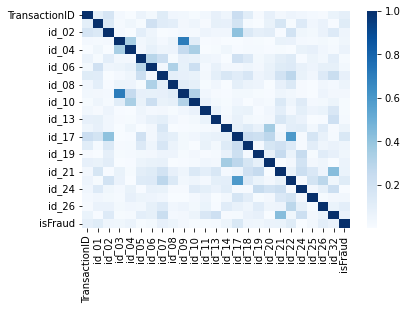

In [420]:
sns.heatmap(abs(id_df.corr()), cmap='Blues');

In [421]:
id_grp = naive_reduce(id_df.corr())
id_grp = [grp for grp in id_grp if len(grp) > 1]
id_grp

[]